### EDS 296: Assignment 1

Author: Liz Peterson
Date: 4-21-2025

In [2]:
# Import necessary packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs

In [3]:
# Open the CMIP6 data catalog & store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

I've chosen to look at heatwaves and water scarcity in the Southwestern US. To investigate this, I am using the `CanESM5` and `GFDL-ESM4` models. I want to look at surface air temperature as a proxy for investigating heatwaves. This is a very hot and arid place. Heat waves and rising surface temperatures are a threat that can lead to water scarcity. 

In [4]:
# Specify search terms to query catalog for my two models 
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP']

# source_id: which model do you want? 
source_id = ['CanESM5', 'GFDL-ESM4']

# experiment_id: what experimental configuration do you want? Here we want historical and the basic 4 scenarios
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = 'r1i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon'

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas'

In [5]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
4,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
5,ScenarioMIP,CCCma,CanESM5,ssp370,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
6,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
7,ScenarioMIP,CCCma,CanESM5,ssp126,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
8,ScenarioMIP,CCCma,CanESM5,ssp245,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
9,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


Now that I have my scenarios saved in my df, I want to bring together my historical and projection data. I am going to use ssp245 for a middle of the road projection and ssp370 for a high emissions scenario. First, I'm going to read in the historical and projection data for my two models, then I'll combine them. 

In [6]:
# Extract data for the historical period for CanESM5
hist_can = xr.open_zarr(res.df['zstore'][6], storage_options={'anon': True})

# Extract data for the historical period for GFDL-ESM4
hist_gfdl = xr.open_zarr(res.df['zstore'][9], storage_options={'anon': True})

# Extract data for ssp245 for CanESM5
ssp245_can = xr.open_zarr(res.df['zstore'][8], storage_options={'anon': True})

# Extract data for ssp370 for CanESM5
ssp370_can = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True})

# Extract data for ssp245 for GFDL-ESM4
ssp245_gfdl = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

# Extract data for ssp370 for GFDL-ESM4
ssp370_gfdl = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})

In [7]:
# Concatenate historical and future projection data - SSP245 CanE5M5
can_245 = xr.concat([hist_can, ssp245_can], dim="time")

# Concatenate historical and future projection data - SSP370 CanESM5
can_370 = xr.concat([hist_can, ssp370_can], dim="time")

# Concatenate historical and future projection data - SSP245 GFDL-ESM4
gfdl_245 = xr.concat([hist_gfdl, ssp245_gfdl], dim="time")

# Concatenate historical and future projection data - SSP370 GFDL-ESM4
gfdl_370 = xr.concat([hist_gfdl, ssp370_gfdl], dim="time")

Now that I have all of my data, I want to revist the spatial aspect of the assignment. I am going to define my bounding box around the Southwestern US and then plot from there! Specifically, this bounding box defines the region around Arizona, Nevada, California, Utah, and New Mexico. I'm going to average the lat and lon for each model combination.

Let's start with the CanESM5 Model SSP 245 Projection

In [8]:
# Define min/max bounds for region of interest 
lat_min, lat_max = 31, 37
lon_min, lon_max = 245, 257

# Define logical mask for can
tas_can245_lat = (can_245.lat >= lat_min) & (can_245.lat <= lat_max)
tas_can245_lon = (can_245.lon >= lon_min) & (can_245.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_can245 = can_245.where(tas_can245_lat & tas_can245_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_can245 = tas_can245.mean(dim=["lat", "lon"])

# Select our time period of interest
tas_can245 = tas_can245.convert_calendar('standard', use_cftime=False)
tas_can245_hist = tas_can245.sel(time=slice('1850-01-01','2015-12-31'))
tas_can245_proj = tas_can245.sel(time=slice('1850-01-01','2100-12-31'))

# Calculate annual mean temperature for both time series
annual_mean_can245_hist = tas_can245_hist.groupby('time.year').mean()
annual_mean_can245_proj = tas_can245_proj.groupby('time.year').mean()

# Convert temperature to Celsius
annual_mean_can245_hist_c = annual_mean_can245_hist - 273.15
annual_mean_can245_proj_c = annual_mean_can245_proj - 273.15


# Extract the 'tas' variable as a DataArray & 'year'
tas1_hist = annual_mean_can245_hist_c['tas']
years1_hist = tas1_hist.year.values
temps1_hist = tas1_hist.values

tas1_proj = annual_mean_can245_proj_c['tas']
years1_proj = tas1_proj.year.values
temps1_proj = tas1_proj.values

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x1_hist = np.polyfit(tas1_hist.year.values, tas1_hist.values, 1)
x1_proj = np.polyfit(tas1_proj.year.values, tas1_proj.values, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_hist = np.poly1d(x1_hist) 
trend_line_proj = np.poly1d(x1_proj) 

Historical plot (1850-2015)

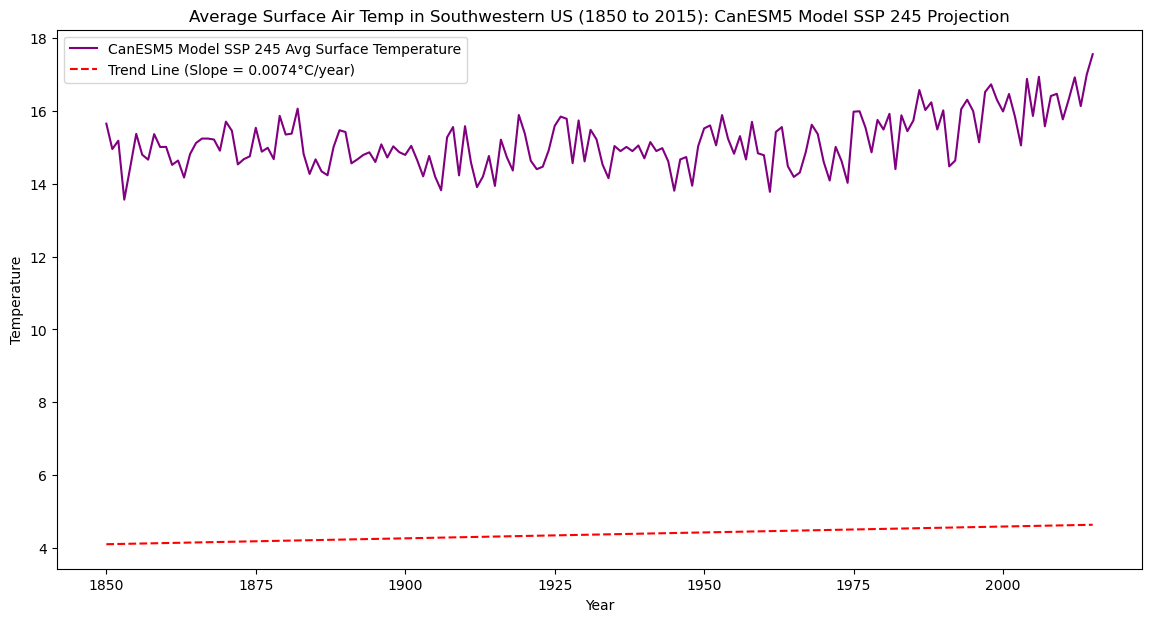

In [22]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years1_hist, temps1_hist, label= 'CanESM5 Model SSP 245 Avg Surface Temperature', color='purple')
ax.plot(years1_hist, trend_line_hist(years1_hist), color='red', linestyle='--', label=f'Trend Line (Slope = {x1_hist[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2015): CanESM5 Model SSP 245 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

Historical + projection plot (1850-2100)

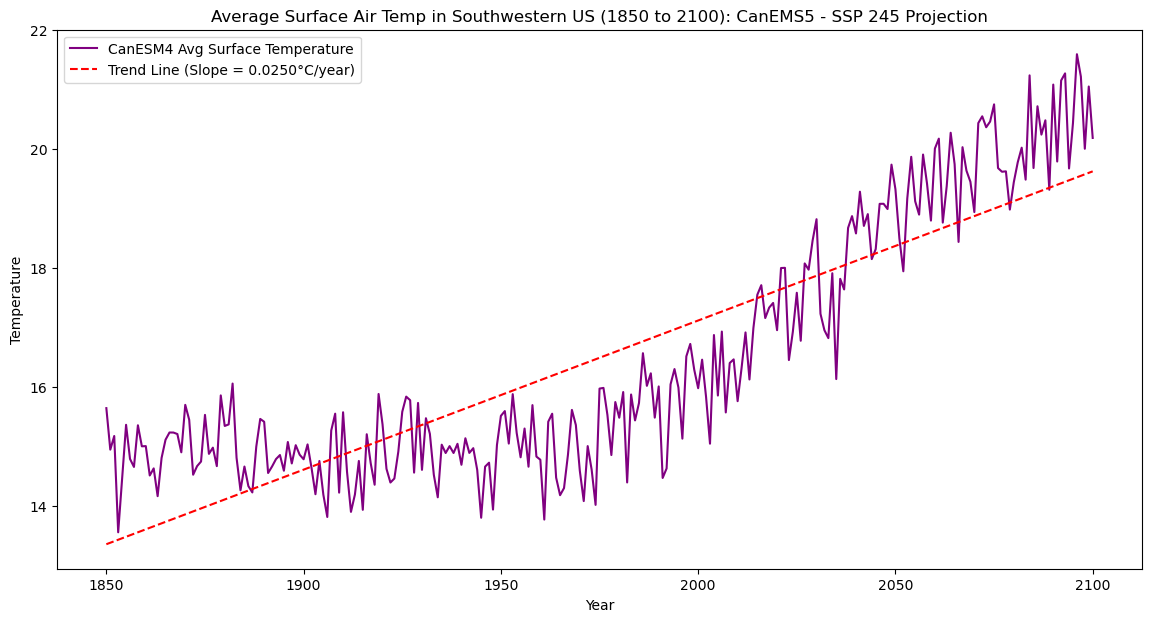

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years1_proj, temps1_proj, label= 'CanESM5 Model SSP 245 Avg Surface Temperature', color='purple')
ax.plot(years1_proj, trend_line_proj(years1_proj), color='red', linestyle='--', label=f'Trend Line (Slope = {x1_proj[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2100): CanESM5 Model SSP 245 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

CanESM5 Model SSP 370 Projection

In [12]:
# Define min/max bounds for region of interest 
lat_min, lat_max = 31, 37
lon_min, lon_max = 245, 257

# Define logical mask for can
tas_can370_lat = (can_370.lat >= lat_min) & (can_370.lat <= lat_max)
tas_can370_lon = (can_370.lon >= lon_min) & (can_370.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_can370 = can_370.where(tas_can370_lat & tas_can370_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_can370 = tas_can370.mean(dim=["lat", "lon"])

# Select our time period of interest
tas_can370 = tas_can370.convert_calendar('standard', use_cftime=False)
tas_can370_hist = tas_can370.sel(time=slice('1850-01-01','2015-12-31'))
tas_can370_proj = tas_can370.sel(time=slice('1850-01-01','2100-12-31'))

# Calculate annual mean temperature for both time series
annual_mean_can370_hist = tas_can370_hist.groupby('time.year').mean()
annual_mean_can370_proj = tas_can370_proj.groupby('time.year').mean()

# Convert temperature to Celsius
annual_mean_can370_hist_c = annual_mean_can370_hist - 273.15
annual_mean_can370_proj_c = annual_mean_can370_proj - 273.15


# Extract the 'tas' variable as a DataArray & 'year'
tas2_hist = annual_mean_can370_hist_c['tas']
years2_hist = tas2_hist.year.values
temps2_hist = tas2_hist.values

tas2_proj = annual_mean_can370_proj_c['tas']
years2_proj = tas2_proj.year.values
temps2_proj = tas2_proj.values

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x2_hist = np.polyfit(tas2_hist.year.values, tas2_hist.values, 1)
x2_proj = np.polyfit(tas2_proj.year.values, tas2_proj.values, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_hist = np.poly1d(x2_hist) 
trend_line_proj = np.poly1d(x2_proj) 

Historical plot (1850-2015)

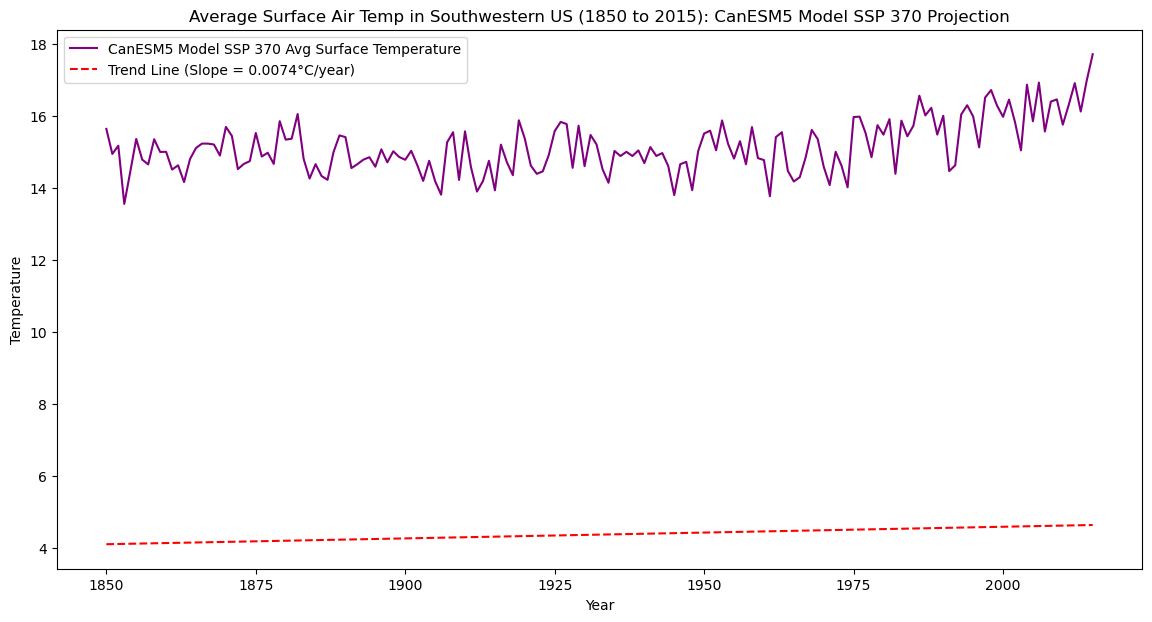

In [23]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years2_hist, temps2_hist, label= 'CanESM5 Model SSP 370 Avg Surface Temperature', color='purple')
ax.plot(years2_hist, trend_line_hist(years2_hist), color='red', linestyle='--', label=f'Trend Line (Slope = {x2_hist[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2015): CanESM5 Model SSP 370 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

Historical + projections plot (1850-2100)

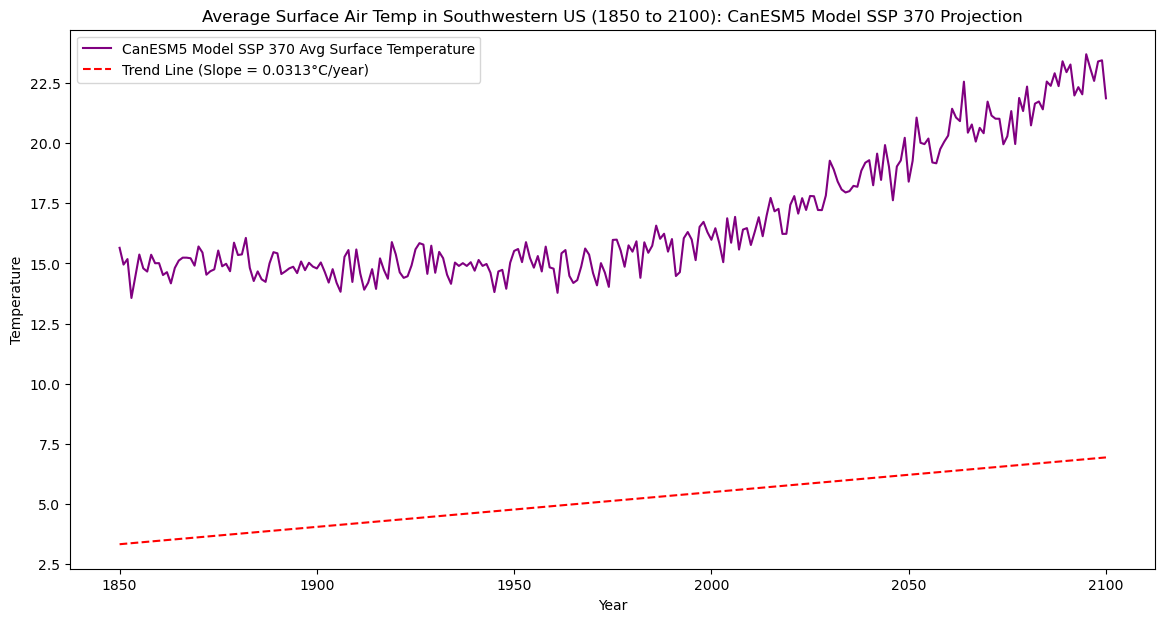

In [24]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years2_proj, temps2_proj, label= 'CanESM5 Model SSP 370 Avg Surface Temperature', color='purple')
ax.plot(years2_proj, trend_line_proj(years2_proj), color='red', linestyle='--', label=f'Trend Line (Slope = {x2_proj[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2100): CanESM5 Model SSP 370 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

GFDL-ESM4 Model SSP 245 Projection

In [16]:
# Define min/max bounds for region of interest 
lat_min, lat_max = 31, 37
lon_min, lon_max = 245, 257

# Define logical mask for can
tas_gfdl245_lat = (gfdl_245.lat >= lat_min) & (gfdl_245.lat <= lat_max)
tas_gfdl245_lon = (gfdl_245.lon >= lon_min) & (gfdl_245.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_gfdl245 = gfdl_245.where(tas_gfdl245_lat & tas_gfdl245_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_gfdl245 = gfdl_245.mean(dim=["lat", "lon"])

# Select our time period of interest
tas_gfdl245 = tas_gfdl245.convert_calendar('standard', use_cftime=False)
tas_gfdl245_hist = tas_gfdl245.sel(time=slice('1850-01-01','2015-12-31'))
tas_gfdl245_proj = tas_gfdl245.sel(time=slice('1850-01-01','2100-12-31'))

# Calculate annual mean temperature for both time series
annual_mean_gfdl245_hist = tas_gfdl245_hist.groupby('time.year').mean()
annual_mean_gfdl245_proj = tas_gfdl245_proj.groupby('time.year').mean()

# Convert temperature to Celsius
annual_mean_gfdl245_hist_c = annual_mean_gfdl245_hist - 273.15
annual_mean_gfdl245_proj_c = annual_mean_gfdl245_proj - 273.15


# Extract the 'tas' variable as a DataArray & 'year'
tas3_hist = annual_mean_gfdl245_hist_c['tas']
years3_hist = tas3_hist.year.values
temps3_hist = tas3_hist.values

tas3_proj = annual_mean_gfdl245_proj_c['tas']
years3_proj = tas3_proj.year.values
temps3_proj = tas3_proj.values

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x3_hist = np.polyfit(tas3_hist.year.values, tas3_hist.values, 1)
x3_proj = np.polyfit(tas3_proj.year.values, tas3_proj.values, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_hist = np.poly1d(x3_hist) 
trend_line_proj = np.poly1d(x3_proj) 

Historical plot (1850-2015)

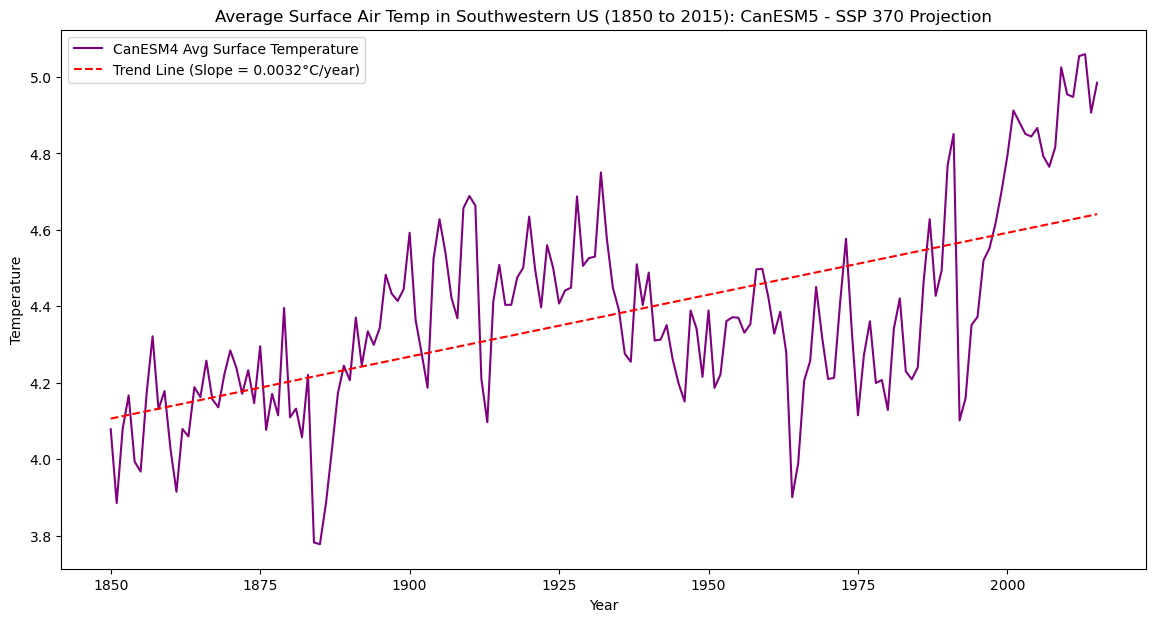

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years3_hist, temps3_hist, label= 'GFDL-ESM4 Model SSP 245 Avg Surface Temperature', color='purple')
ax.plot(years3_hist, trend_line_hist(years3_hist), color='red', linestyle='--', label=f'Trend Line (Slope = {x3_hist[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2015): GFDL-ESM4 Model SSP 245 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

Historical + projections plot (1850-2100)

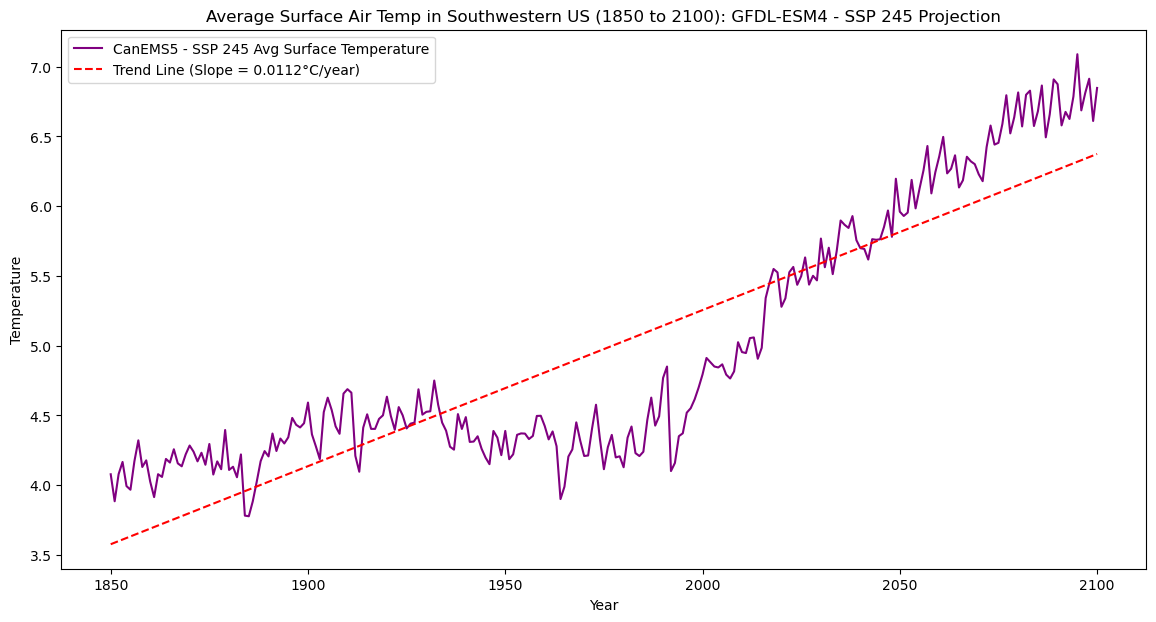

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years3_proj, temps3_proj, label= 'GFDL-ESM4 Model SSP 245 Avg Surface Temperature', color='purple')
ax.plot(years3_proj, trend_line_proj(years3_proj), color='red', linestyle='--', label=f'Trend Line (Slope = {x3_proj[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2100): GFDL-ESM4 Model SSP 245 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

GFDL-ESM4 Model SSP 370 Projection

In [19]:
# Define min/max bounds for region of interest 
lat_min, lat_max = 31, 37
lon_min, lon_max = 245, 257

# Define logical mask for can
tas_gfdl370_lat = (gfdl_370.lat >= lat_min) & (gfdl_370.lat <= lat_max)
tas_gfdl370_lon = (gfdl_370.lon >= lon_min) & (gfdl_370.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_gfdl370 = gfdl_370.where(tas_gfdl370_lat & tas_gfdl245_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_gfdl370 = gfdl_370.mean(dim=["lat", "lon"])

# Select our time period of interest
tas_gfdl370 = tas_gfdl370.convert_calendar('standard', use_cftime=False)
tas_gfdl370_hist = tas_gfdl370.sel(time=slice('1850-01-01','2015-12-31'))
tas_gfdl370_proj = tas_gfdl370.sel(time=slice('1850-01-01','2100-12-31'))

# Calculate annual mean temperature for both time series
annual_mean_gfdl370_hist = tas_gfdl370_hist.groupby('time.year').mean()
annual_mean_gfdl370_proj = tas_gfdl370_proj.groupby('time.year').mean()

# Convert temperature to Celsius
annual_mean_gfdl370_hist_c = annual_mean_gfdl370_hist - 273.15
annual_mean_gfdl370_proj_c = annual_mean_gfdl370_proj - 273.15


# Extract the 'tas' variable as a DataArray & 'year'
tas4_hist = annual_mean_gfdl370_hist_c['tas']
years4_hist = tas4_hist.year.values
temps4_hist = tas4_hist.values

tas4_proj = annual_mean_gfdl370_proj_c['tas']
years4_proj = tas4_proj.year.values
temps4_proj = tas4_proj.values

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x4_hist = np.polyfit(tas4_hist.year.values, tas4_hist.values, 1)
x4_proj = np.polyfit(tas4_proj.year.values, tas4_proj.values, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_hist = np.poly1d(x4_hist) 
trend_line_proj = np.poly1d(x4_proj) 

Historical plot (1850-2015)

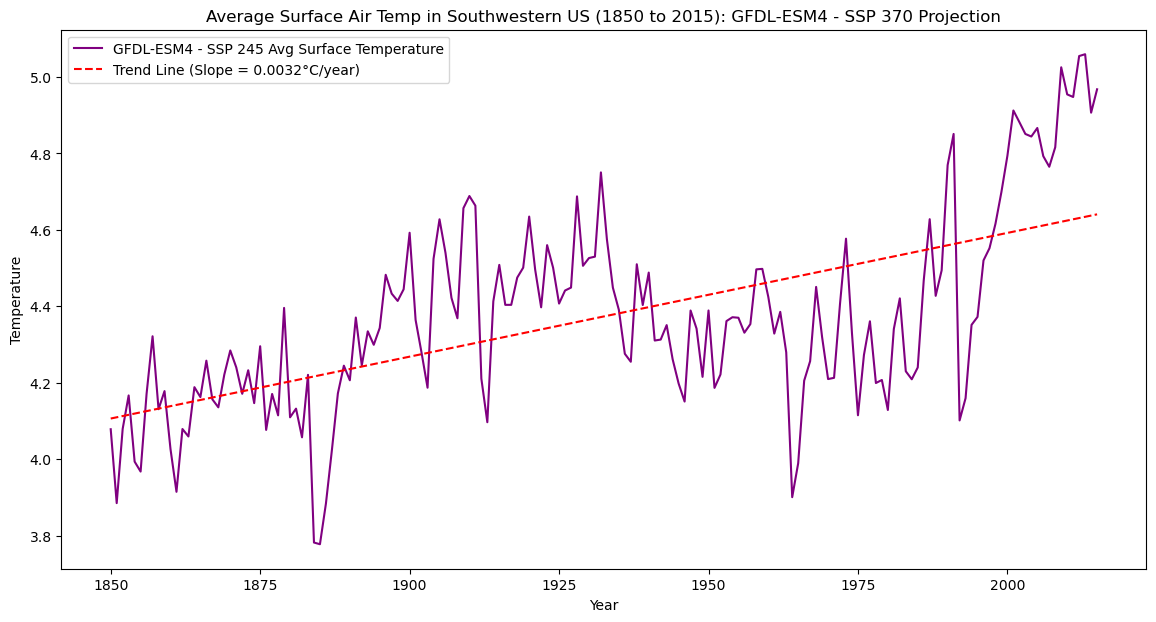

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years4_hist, temps4_hist, label= 'GFDL-ESM4 Model SSP 370 Avg Surface Temperature', color='purple')
ax.plot(years4_hist, trend_line_hist(years4_hist), color='red', linestyle='--', label=f'Trend Line (Slope = {x4_hist[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2015): GFDL-ESM4 Model SSP 370 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

Historical + projections plot (1850-2100)

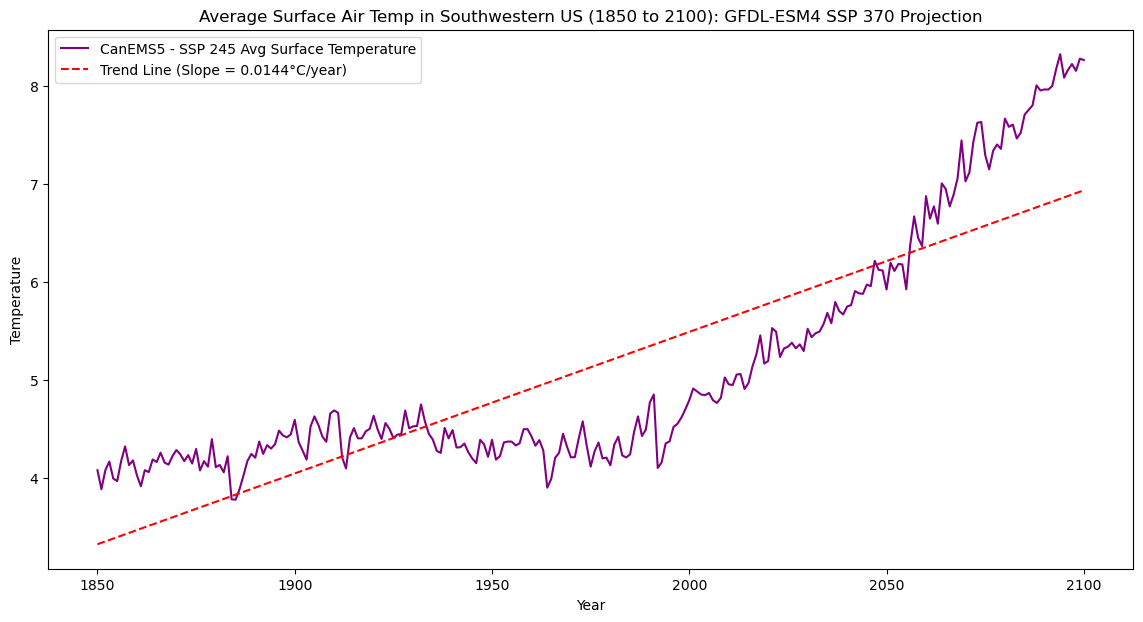

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(years4_proj, temps4_proj, label= 'CanEMS5 - SSP 245 Avg Surface Temperature', color='purple')
ax.plot(years4_proj, trend_line_proj(years4_proj), color='red', linestyle='--', label=f'Trend Line (Slope = {x4_proj[0]:.4f}°C/year)')
ax.set_title('Average Surface Air Temp in Southwestern US (1850 to 2100): GFDL-ESM4 - SSP 370 Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()